### Sigma Cabs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

import warnings
warnings.filterwarnings('ignore')

We will work with data from the taxi aggregator [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). Depending on the characteristics of the trip, one of three types of increased pricing needs to be predicted: [1, 2, 3]. Thus, this will help the company optimally match taxis and customers.

In [4]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [5]:
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Features:

- **Trip_ID**: ID for TRIP

- **Trip_Distance**: The distance for the trip requested by the customer

- **Type_of_Cab**: Category of the cab requested by the customer

- **Customer_Since_Months**: Customer using cab services since n months; 0 month means current month

- **Life_Style_Index**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour

- **Confidence_Life_Style_Index**: Category showing confidence on the index mentioned above

- **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.

- **Customer_Rating**: Average of life time ratings of the customer till date

- **Cancellation_Last_1Month**: Number of trips cancelled by the customer in last 1 month

- **Var1, Var2 and Var3**: Continuous variables masked by the company. Can be used for modelling purposes

- **Gender**: Gender of the customer

- **Surge_Pricing_Type**: Target (can be of 3 types)


### EDA 
Let's fill in the gaps in real features with the median, and in categorical ones - with the most popular class. Let's draw a correlation matrix and display the top 5 pairs of the most correlated features.

Since the sum of the unique values ​​of various categorical features will not be very many, we will use `One-Hot-Encoding` for them.

In [6]:
# Let's look at the class balance
df['Surge_Pricing_Type'].value_counts()

2    56728
3    47720
1    27214
Name: Surge_Pricing_Type, dtype: int64

In [7]:
# Missing variables in real characteristics
num_cols = df.select_dtypes(exclude='object').columns
df[num_cols].isna().sum()

Trip_Distance                   0
Customer_Since_Months        5920
Life_Style_Index            20193
Customer_Rating                 0
Cancellation_Last_1Month        0
Var1                        71030
Var2                            0
Var3                            0
Surge_Pricing_Type              0
dtype: int64

In [8]:
# Fill with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

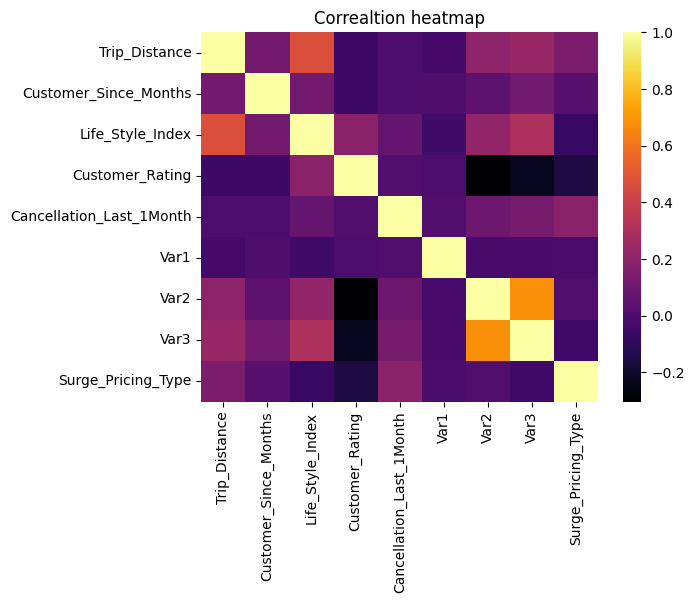

In [9]:
plt.title("Correaltion heatmap")
sns.heatmap(df[num_cols].corr(), cmap='inferno');

In [10]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df[num_cols])

Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Var3                0.303324
Customer_Rating   Var2                0.302968
Trip_Distance     Var3                0.231706
dtype: float64

In [11]:
df.describe(include='object')

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,111452,111469,131662,131662
unique,5,3,14,2
top,B,B,A,Male
freq,31136,40355,77597,93900


In [12]:
# We will fill in the gaps in categorical values with the most popular value.
df = df.fillna(df.mode().iloc[0])
df.isna().sum()

Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

In [13]:
# There are not many classes, you can use OHE
df.select_dtypes('object').nunique()

Type_of_Cab                     5
Confidence_Life_Style_Index     3
Destination_Type               14
Gender                          2
dtype: int64

In [14]:
# Let's encode categorical features
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

### Training

In [17]:
np.random.seed(2022)

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

Let's train One-vs-Rest Logreg. Let's calculate precision, recall, f1-score and average across all classes using micro, macro and weighted avg.

In [18]:
# Training
logit = LogisticRegression()
pipe1 = Pipeline([('scaler', StandardScaler()), 
                  ('one_vs_all', OneVsRestClassifier(logit))])

pipe1.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [19]:
print(classification_report(y_test, pipe1.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Let's select the optimal hyperparameters of the model using `GridSearchCV()` from those proposed. We will validate the parameters using `accuracy`.

To do this, we will pass the training part of our data to the `fit` method, we will not pass anything to the `cv` parameter (by default, 5-fold Cross-Validation will be carried out), and we will measure the final metrics on the test!

In [20]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [21]:
# Selection of parameters

grid1 = GridSearchCV(pipe1, param_grid, cv=5)
grid1.fit(X_train, y_train)

print(f"Best parameters: {grid1.best_params_}")
print(classification_report(y_test, grid1.predict(X_test), digits=3))

Best parameters: {'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Let's plot three calibration curves for the Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest.

In [22]:
grid1.predict_proba(X_test)

array([[0.3062245 , 0.27486411, 0.41891139],
       [0.02308103, 0.5404543 , 0.43646468],
       [0.02306905, 0.55678486, 0.42014609],
       ...,
       [0.48673502, 0.10505849, 0.4082065 ],
       [0.5666375 , 0.18013107, 0.25323143],
       [0.13873848, 0.59998973, 0.26127179]])

In [23]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1))

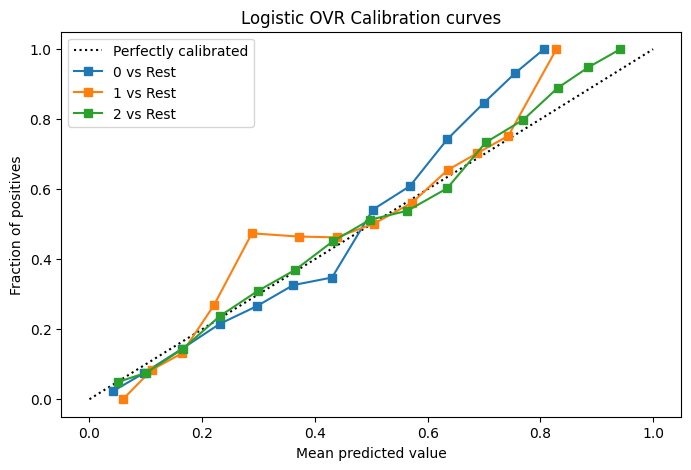

In [24]:
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# calibration curves
for label in range(3):
    prob_pos = grid1.predict_proba(X_test)[:, label]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_ohe[:, label],
                                                                    prob_pos,
                                                                    n_bins=15)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{label} vs Rest")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title('Logistic OVR Calibration curves')
plt.legend();

The curves are quite close to the diagonal! Well calibrated.

Let's train a One-vs-One `SGDClassifier` from `sklearn.linear_model` that uses stochastic gradient descent

Let's calculate precision, recall, f1-score and average across all classes using micro, macro and weighted avg.

In [30]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [31]:
# Training
pipe_ovo = Pipeline([('scaler', StandardScaler()), 
                     ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])

pipe_ovo.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one', OneVsOneClassifier(estimator=SGDClassifier()))])

In [32]:
print(classification_report(y_test, pipe_ovo.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.521     0.614      5372
           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333



Let's select the optimal hyperparameters of the model using `GridSearchCV()`. At the same time, we will go through all possible loss functions. Thus, with `loss = 'hinge'` we will train an SVM, with `loss = 'log'` we will train a logistic regression, etc.

In [33]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [34]:
%%time

grid_ovo = GridSearchCV(pipe_ovo, param_grid, cv=5)
grid_ovo.fit(X_train, y_train)

print(f"Best parameters: {grid_ovo.best_params_}")
print(classification_report(y_test, grid_ovo.predict(X_test), digits=3))

Best parameters: {'one_vs_one__estimator__alpha': 0.1, 'one_vs_one__estimator__loss': 'modified_huber', 'one_vs_one__estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           1      0.748     0.529     0.620      5372
           2      0.633     0.845     0.724     11349
           3      0.745     0.572     0.647      9612

    accuracy                          0.681     26333
   macro avg      0.709     0.649     0.663     26333
weighted avg      0.697     0.681     0.675     26333

CPU times: user 2min 36s, sys: 8.07 s, total: 2min 44s
Wall time: 2min 31s


Is it possible to say unequivocally which approach was better: One-vs-Rest or One-vs-One?

Each approach seems to have its pros and cons.